In [1]:
import calour as ca
ca.set_log_level(11)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from collections import defaultdict
import numpy as np

# NOTE: we run this notebook on a local dbBact server since large queries to the database
# NOTE2: need to delete all annotations>3925 to enable statistics only based on these annotations (for dbBact release 1.0)
## in SQL write:
### DELETE FROM SequencesAnnotationTable WHERE annotationid>3925;
## and then update the dbBact statistics by running the script:
### (if running on local develop database)
### dbbact_jobs/update_seq_counts.py --database dbbact_develop --password dbbact_develop --user dbbact_develop

In [4]:
# use the amnon calour config file
import os
os.environ['CALOUR_CONFIG_FILE']='/Users/amnon/git/calour/calour/calour.config.local'

In [5]:
def get_all_annotations(limit=[], annotations_to_get=None, max_id=None, primer=None):
    '''Get all the teature_ids associated with each term in the database

    Parameters
    ----------
    limit : list of str (optional)
        Only use annotations that contain all these terms
    annotations_to_get: list of int or None (optional)
        None to get all annotation sequences
        if not none, AnnotationIDs to get
    max_id: int or None, optional
        if not None, use only annotations up to id max_id
    primer: str or None, optional
        if not None, get only annotations from a specific primer region (i.e. 'v4')

    Returns
    -------
    dict of {str: {int: int}}
        dict of {term : {feature_id : count}}
        key is term, value is dict where key is the feature_id (int from dbBact), value is the number of annotations (containing the term) with the feature
    '''
    from collections import defaultdict
    print('getting all annotations list from dbBact')
    db = ca.database._get_database_class('dbbact')
    res = db.db._get('annotations/get_all_annotations', {}, param_json=True)
    res = res.json()
    annotations = res['annotations']
    print('got %d annotations' % len(annotations))
    if max_id is not None:
        annotations = [x for x in annotations if x['annotationid']<= max_id]
        print('filtered max_id=%d, got %d annotations remaining' % (max_id, len(annotations)))
    if primer is not None:
        annotations = [x for x in annotations if x['primer']==primer]
        print('filtered region %s. only %d annotations remaining' % (primer, len(annotations)))
    return annotations

In [6]:
def get_all_annotation_seqs(annotations, annotations_to_get=None):
    print('getting sequences per annotation')
    annotation_seqs={}
    failed_ann = []
    for idx, cannotation in enumerate(annotations):
        if annotations_to_get is not None:
            if cannotation['annotationid'] not in annotations_to_get:
                continue
        if (idx*100 / len(annotations)).is_integer():
            print(idx)
        try:
            seqs = db.db.get_annotation_sequences(cannotation['annotationid'])
        except Exception as err:
            print('error for idx %d annotation %s' % (idx, cannotation['annotationid']))
            print(err)
            failed_ann.append(cannotation)
            continue
        annotation_seqs[cannotation['annotationid']] = seqs
    print('getting %d failed annotations' % len(failed_ann))
    for idx, cannotation in enumerate(failed_ann):
        if annotations_to_get is not None:
            if cannotation['annotationid'] not in annotations_to_get:
                continue
        if (idx*100 / len(annotations)).is_integer():
            print(idx)
        try:
            seqs = db.get_annotation_sequences(cannotation['annotationid'])
        except:
            print('error for idx %d annotation %s' % (idx, cannotation['annotationid']))
            continue
        annotation_seqs[cannotation['annotationid']] = seqs
    return annotation_seqs


In [7]:
# ann = get_all_annotations(max_id=3925)
ann = get_all_annotations(primer='v4')

getting all annotations list from dbBact
creating logger
got 6072 annotations
filtered region v4. only 5084 annotations remaining


In [8]:
def count_terms(ann):
    terms=defaultdict(int)
    term_exps=defaultdict(set)
    term_exps_counts=defaultdict(int)
    for cann in ann:
        for cdetail in cann['details']:
            terms[cdetail[1]] += 1
            term_exps[cdetail[1]].add(cann['expid'])
    for cterm,cexps in term_exps.items():
        term_exps_counts[cterm]=len(cexps)
    return terms,term_exps_counts

In [9]:
allterms,allterms_exps = count_terms(ann)

In [10]:
len(allterms)

2712

In [11]:
def plot_allterms_hist(allterms):
    all_num=[]
    all_names=[]
    for cterm,cnum in allterms.items():
        all_num.append(cnum)
        all_names.append(cterm)
    plt.figure()
    plt.hist(all_num,100)
    plt.yscale('log')
    plt.xlabel('Number of annotations')
    plt.ylabel('Number of terms')

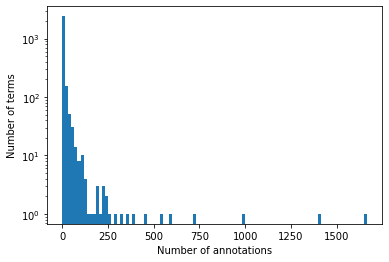

In [12]:
plot_allterms_hist(allterms)

# Figure 3C - terms scatter plot
## number of annotations and experiments where each term appears

In [16]:
def plot_term_scatter(allterms, min_num_annotations=250):
    '''Plot a scatter plot for number of annotations and experiments with each term
    
    Parameters
    ----------
    allterms
    min_num_annotations: int, optional
        Put a text label for all terms with number of annotations > min_num_annotations
        
    Returns
    -------
    figure
    '''
    import operator
    sorted_allterms = sorted(allterms.items(), key=operator.itemgetter(1))
    f = plt.figure()
    ax=plt.gca()
    for cterm,ccount in allterms.items():
        expcount=allterms_exps[cterm]
        plt.plot(ccount,expcount,'ok')
        if ccount>250:
    #         ax.annotate(cterm, xy=(ccount, expcount),  xycoords='data')
            ax.annotate(cterm, xy=(ccount, expcount),  xycoords='data',
                        xytext=(2,2),textcoords='offset points')
    plt.xlabel('number of annotations')
    plt.ylabel('number of experiments')
    return f

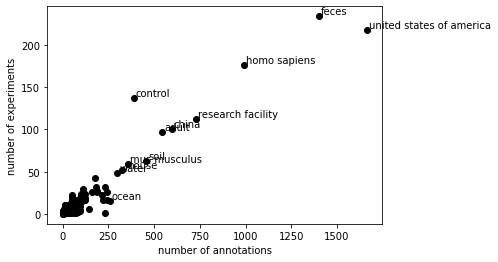

In [17]:
f=plot_term_scatter(allterms)

In [18]:
f.savefig('fig3c-term-scatter.pdf')

# Figure 3D - number of annotations per sequence

In [19]:
db = ca.database._get_database_class('dbbact')


In [20]:
seqs = [x for x in range(300000)]

In [21]:
res = db.db._get('sequences/get_info',{'seqids':seqs})

In [22]:
seqinfo=res.json()['sequences']
print(len(seqinfo))

300000


In [23]:
seqinfo[3]

{'seq': 'tacggaaggtccgggcgttatccggaattattgggtttaaagggagcgcaggcgggagtgtaagtcagctgttaaatatcagggcccaactctgttatgcagttgaaactatatttcttgagtacgcacagggatggcggaattcagggt',
 'taxonomy': 'd__Bacteria;p__"Bacteroidetes";c__"Bacteroidia";o__"Bacteroidales";f__"Prevotellaceae";g__Alloprevotella',
 'seqid': 3,
 'total_annotations': 23,
 'total_experiments': 16}

## Count the number of sequences with 1 , >1, >=10 experiments

In [29]:
# more than 1 experiment
g1e=[]
# >=10 experiments
g10e=[]
# all sequences
ga=[]
# exactly 1 experiment
o1e=[]
for ci in seqinfo:
    if 'total_experiments' not in ci:
        continue
    ga.append(ci)
    te=ci['total_experiments']
    if te==1:
        o1e.append(ci)
    if te>1:
        g1e.append(ci)
    if te>=10:
        g10e.append(ci)

In [30]:
len(g1e)

81485

In [31]:
len(g10e)

7322

In [32]:
len(ga)

280756

In [33]:
len(o1e)

199223

## info about e. coli

In [35]:
for ci in seqinfo:
    if ci['seq']=='tacggagggtgcaagcgttaatcggaattactgggcgtaaagcgcacgcaggcggtttgttaagtcagatgtgaaatccccgggctcaacctgggaactgcatctgatactggcaagcttgagtctcgtagaggggggtagaattccagg':
        print(ci)

{'seq': 'tacggagggtgcaagcgttaatcggaattactgggcgtaaagcgcacgcaggcggtttgttaagtcagatgtgaaatccccgggctcaacctgggaactgcatctgatactggcaagcttgagtctcgtagaggggggtagaattccagg', 'taxonomy': 'd__Bacteria;p__"Proteobacteria";c__Gammaproteobacteria;o__"Enterobacteriales";f__Enterobacteriaceae;g__Escherichia/Shigella', 'seqid': 2762, 'total_annotations': 901, 'total_experiments': 319}


# Plot the Experiments per sequence histogram

In [33]:
def plot_annotations_per_sequence(seqinfo, show_name_thresh=350,field='total_experiments'):
    '''Plot the histogram of annotations per sequence
    
    Parameters
    ----------
    seqinfo: resullt of the dbact sequences/get_info (the 'sequences' json)
    show_name_thresh: int, optional
        show the bacteria names for any bacteria found in > show_name_thresh annotations
    field: str, optional
        'total_experiments' to show number of experiments each sequence appears in
        'total_annotations' to show number of annotations each sequence appears in
    '''
    f = plt.figure()
    field='total_experiments'
    seqcounts = [x[field] for x in seqinfo if field in x]
    print('total %d sequences' % len(seqcounts))
    ax=plt.gca()
    res=plt.hist(seqcounts, bins=100)
    plt.yscale('log')
    plt.xlabel(field)
    plt.ylabel('Number of sequences')
    labely = 1
    for cseqinfo in seqinfo:
        if field not in cseqinfo:
            continue
        ccount = cseqinfo[field]
        if ccount > show_name_thresh:
            cname = cseqinfo['taxonomy']
            print('%d: %s' % (ccount, cname))
            print(cseqinfo['seq'])
            ax.annotate(cname, xy=(ccount, labely),  xycoords='data',
                        xytext=(0, 70),textcoords='offset points',arrowprops={'width':2},annotation_clip=False)
            labely = labely*3

    f2=plt.figure()
    plt.hist(seqcounts, bins=10,range=[1,10])
    plt.yscale('log')
    plt.xlabel(field)
    plt.ylabel('Number of sequences')
    plt.ylim(1000,300000)
    return f,f2

total 280756 sequences
171: d__Bacteria;p__"Proteobacteria";c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae
tacggagggtgcgagcgttaatcggaataactgggcgtaaagggcacgcaggcggtgacttaagtgaggtgtgaaagccccgggcttaacctgggaattgcatttcatactgggtcgctagagtactttagggaggggtagaattccacg
177: d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus
tacgtaggtcccgagcgttgtccggatttattgggcgtaaagcgagcgcaggcggttagataagtctgaagttaaaggctgtggcttaaccatagtacgctttggaaactgtttaacttgagtgcaagaggggagagtggaattccatgt
228: d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus
tacgtaggtcccgagcgttgtccggatttattgggcgtaaagcgagcgcaggcggtttgataagtctgaagttaaaggctgtggctcaaccatagttcgctttggaaactgtcaaacttgagtgcagaaggggagagtggaattccatgt
210: d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus
tacgtaggtggcaagcgttatccggaattattgggcgtaaagcgcgcgtaggcggttttttaagtctgatgtgaaagcccacggctcaaccgtggagggtcattggaaactggaaaacttgagtgcagaagaggaa

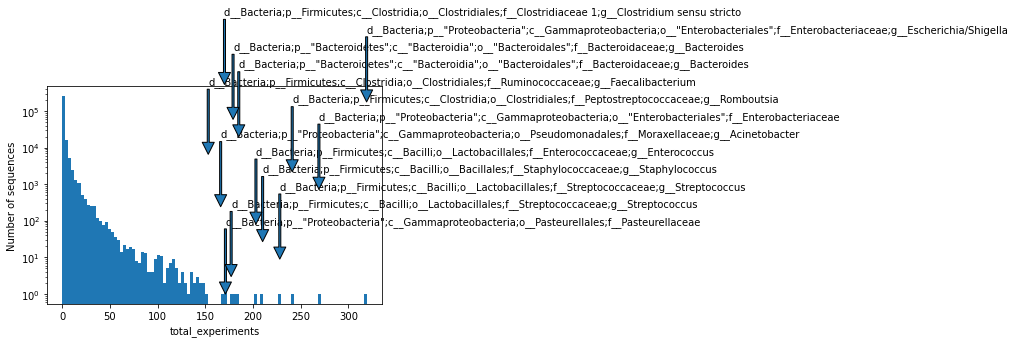

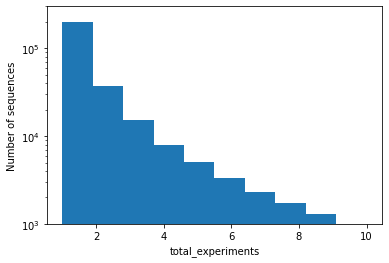

In [34]:
f,f2=plot_annotations_per_sequence(seqinfo,show_name_thresh=150)

# blast results for taxonomy:
* tacggagggtgcaagcgttaatcggaattactgggcgtaaagcgcacgcaggcggtttgttaagtcagatgtgaaatccccgggctcaacctgggaactgcatctgatactggcaagcttgagtctcgtagaggggggtagaattccagg : e. coli / shigella
(243: d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae)

* tacgtagggggctagcgttatccggaattactgggcgtaaagggtgcgtaggtggtttcttaagtcagaggtgaaaggctacggctcaaccgtagtaagcctttgaaactgggaaacttgagtgcaggagaggagagtggaattcctagt : Romboutsia
(187: d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Romboutsia)

* tacggagggtgcaagcgttaatcggaattactgggcgtaaagcgcacgcaggcggtctgtcaagtcggatgtgaaatccccgggctcaacctgggaactgcattcgaaactggcaggctagagtcttgtagaggggggtagaattccagg : Enterobacteriaceae (could be enterobacter / pantoea / klebsiella / erwinia...
(215: d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae)

* tacgtaggtggcaagcgttgtccggatttattgggcgtaaagcgagcgcaggcggtttcttaagtctgatgtgaaagcccccggctcaaccggggagggtcattggaaactgggagacttgagtgcagaagaggagagtggaattccatg : Enterococcus
161: d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus

* tacgtaggtggcaagcgttatccggaattattgggcgtaaagcgcgcgtaggcggttttttaagtctgatgtgaaagcccacggctcaaccgtggagggtcattggaaactggaaaacttgagtgcagaagaggaaagtggaattccatg : Staphylococcus (epidermidis / warneri / aureus ...)
165: d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus

* tacgtaggtcccgagcgttgtccggatttattgggcgtaaagcgagcgcaggcggtttgataagtctgaagttaaaggctgtggctcaaccatagttcgctttggaaactgtcaaacttgagtgcagaaggggagagtggaattccatgt : Streptococcus (salivarius / thermophilus / vestibularis)
180: d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus


In [35]:
f.savefig('./fig3d-sequence-exps.pdf',bbox_inches='tight')
f2.savefig('./fig3d-sequence-exps-zoom.pdf')

# Figure 3E - how many new bacteria (comprehensiveness)

In [36]:
def calc_db_coverage(annotations,aseqs,term_list):
    '''Get database comprehensiveness by bootstrapping all experimets containing the terms from term_list
    
    Parameters
    ----------
    annotations, aseqs : from all_term_neighbors2()
    term_list: list of str
        test only annotations contaning all terms from term_list
        
    Returns
    -------
    coverage : mean coverage (how many bacteria from the experiment are present in other experiments)
    covstd: std of the coverage (between different experiments)
    term_list: the terms used
    all_num_reads: number of unique experiments with "common" annotations containing the term
    '''
    term_list=set(term_list)
    test_list=[]
    print('getting relevant annotations')
    explist = set()
    for cannotation in annotations:
        # we only do the bootstrap on 'commmon' annotations
        if cannotation['annotationtype'] != 'common':
            continue
        # check if to add this experiment to the test list
        cann_details = {}
        for cdetail in cannotation['details']:
            cterm = cdetail[1]
            cann_details[cterm] = cdetail[0]
        found_all = True
        for cterm in term_list:
            if cterm not in cann_details:
                found_all = False
                break
        if not found_all:
            continue
        explist.add(cannotation['expid'])
        test_list.append(cannotation)
#     all_num_reads = len(test_list)
    all_num_reads = len(explist)
    print('found %d "common" annotations in %d experiments with terms %s' % (len(test_list), len(explist), term_list))
    all_coverage=[]
    for cannotation in test_list:
        cid = cannotation['annotationid']
        cexp = cannotation['expid']
        cseqs = set(aseqs[cid])
        found_seqs = set()
        for o_annotation in annotations:
            if o_annotation['expid'] == cexp:
                continue
            found_seqs.update(set(aseqs[o_annotation['annotationid']]))
        coverage = len(found_seqs.intersection(cseqs))
        if len(cseqs) > 0:
#         print('annotationid %d found %d/%d' % (cid, coverage, len(cseqs)))
            all_coverage.append(coverage/len(cseqs))
        else:
            print('no sequences for annotation %d exp %d' % (cid, cexp))
    print('mean coverage %f, std %f' % (np.mean(all_coverage), np.std(all_coverage)))
    return np.mean(all_coverage), np.std(all_coverage), ', '.join(list(term_list)), all_num_reads

In [37]:
aseqs = get_all_annotation_seqs(ann)

getting sequences per annotation
0
1271
2542
3813
getting 0 failed annotations


In [38]:
len(aseqs)

5084

In [39]:
calc_db_coverage(ann,aseqs,term_list=['feces','homo sapiens'])

getting relevant annotations
found 164 "common" annotations in 97 experiments with terms {'homo sapiens', 'feces'}
mean coverage 0.981096, std 0.112264


(0.9810964246877742, 0.11226364639897518, 'homo sapiens, feces', 97)

getting relevant annotations
found 164 "common" annotations in 97 experiments with terms {'homo sapiens', 'feces'}
mean coverage 0.981096, std 0.112264
getting relevant annotations
found 22 "common" annotations in 20 experiments with terms {'homo sapiens', 'saliva'}
mean coverage 0.998044, std 0.005278
getting relevant annotations
found 10 "common" annotations in 7 experiments with terms {'homo sapiens', 'skin'}
mean coverage 0.975892, std 0.039670
getting relevant annotations
found 286 "common" annotations in 161 experiments with terms {'homo sapiens'}
mean coverage 0.983636, std 0.088194
getting relevant annotations
found 31 "common" annotations in 19 experiments with terms {'canis lupus familiaris'}
mean coverage 0.957630, std 0.127831
getting relevant annotations
found 16 "common" annotations in 10 experiments with terms {'bos taurus'}
mean coverage 0.870529, std 0.124874
getting relevant annotations
found 159 "common" annotations in 62 experiments with terms {'soil'}
mean coverage

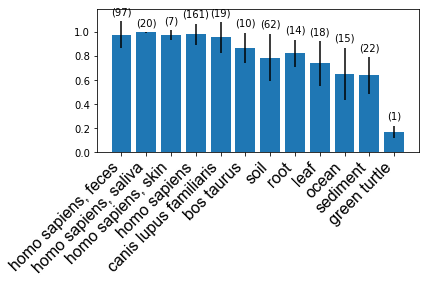

In [40]:
tlist = [['feces', 'homo sapiens'],['saliva','homo sapiens'],['homo sapiens','skin'],['homo sapiens'],
         ['canis lupus familiaris'],['bos taurus'],['soil'],['root'],['leaf'],
         ['ocean'],['sediment'],['green turtle']]
allmean=[]
allstd=[]
alllabel=[]
all_num_reads=[]
for ctlist in tlist:
    cmean,cstd, clabel, cnum_reads = calc_db_coverage(ann,aseqs,term_list=ctlist)
    allmean.append(cmean)
    allstd.append(cstd)
    alllabel.append(clabel)
#     alllabel.append(clabel+' (%d)' % cnum_reads)
    all_num_reads.append(cnum_reads)
import matplotlib.pyplot as plt
%matplotlib inline
f=plt.figure()
x=np.arange(len(allmean))
plt.bar(x,allmean,tick_label=alllabel, yerr=allstd)
plt.xticks(x, alllabel, rotation=45,horizontalalignment='right',fontname='arial',fontsize=16)
for cidx,cx in enumerate(x):
    plt.text(cx,allmean[cidx]+allstd[cidx]+0.05, '(%d)' % all_num_reads[cidx],horizontalalignment='center')
plt.ylim([0,1.19])
plt.tight_layout()


In [41]:
f.savefig('./fig3e-term-comprehensive.pdf')